In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

X_train_full = train_df.drop('smoking', axis=1)
y_train_full = train_df['smoking']
X_test_final = test_df.copy()

print(f"Train: {train_df.shape}, Test: {test_df.shape}")

Train: (38984, 23), Test: (16708, 22)


In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train_full
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

Train: (31187, 22), Val: (7797, 22)


In [4]:
def create_health_features(df):
    df_new = df.copy()
    df_new['BMI'] = df_new['weight(kg)'] / ((df_new['height(cm)'] / 100) ** 2)
    df_new['waist_height_ratio'] = df_new['waist(cm)'] / df_new['height(cm)']
    df_new['total_hdl_ratio'] = df_new['Cholesterol'] / (df_new['HDL'] + 1)
    df_new['ldl_hdl_ratio'] = df_new['LDL'] / (df_new['HDL'] + 1)
    df_new['ast_alt_ratio'] = df_new['AST'] / (df_new['ALT'] + 1)
    df_new['pulse_pressure'] = df_new['systolic'] - df_new['relaxation']
    df_new['eyesight_avg'] = (df_new['eyesight(left)'] + df_new['eyesight(right)']) / 2
    df_new['eyesight_diff'] = np.abs(df_new['eyesight(left)'] - df_new['eyesight(right)'])
    df_new['hearing_avg'] = (df_new['hearing(left)'] + df_new['hearing(right)']) / 2
    df_new['age_squared'] = df_new['age'] ** 2
    df_new['age_cubed'] = df_new['age'] ** 3
    return df_new

X_train_eng = create_health_features(X_train)
X_val_eng = create_health_features(X_val)
X_train_full_eng = create_health_features(X_train_full)
X_test_eng = create_health_features(X_test_final)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_val_scaled = scaler.transform(X_val_eng)
X_train_full_scaled = scaler.transform(X_train_full_eng)
X_test_scaled = scaler.transform(X_test_eng)

print(f"Total features after engineering: {X_train_eng.shape[1]}")

Total features after engineering: 33


In [5]:
# Baseline Model (Default Hyperparameters) on Full Training Set
print("Training Baseline SVM (Default Parameters) on Full Training Split (this may take time)...")
# Using probability=True for consistency in AUC calculation, though it's slower.
baseline_model = SVC(probability=True, random_state=RANDOM_STATE, class_weight='balanced')
baseline_model.fit(X_train_scaled, y_train)

y_pred_baseline = baseline_model.predict(X_val_scaled)
y_prob_baseline = baseline_model.predict_proba(X_val_scaled)[:, 1]

print("Baseline Validation Metrics:")
print(classification_report(y_val, y_pred_baseline))
print(f"Baseline ROC-AUC: {roc_auc_score(y_val, y_prob_baseline):.4f}")

Training Baseline SVM (Default Parameters) on Full Training Split (this may take time)...
Baseline Validation Metrics:
              precision    recall  f1-score   support

           0       0.90      0.61      0.73      4933
           1       0.57      0.88      0.69      2864

    accuracy                           0.71      7797
   macro avg       0.73      0.75      0.71      7797
weighted avg       0.78      0.71      0.71      7797

Baseline ROC-AUC: 0.8221


In [6]:
def objective(trial):
    C = trial.suggest_float('C', 0.1, 10.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    # Standard SVC on ~30k rows can be slow, especially with poly kernel
    # Using probability=True amplifies this
    model = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        class_weight='balanced',
        probability=True,  # Needed for ROC-AUC, but slower. Can use decision_function if probability not needed.
        random_state=RANDOM_STATE
    )
    
    model.fit(X_train_scaled, y_train)
    y_prob = model.predict_proba(X_val_scaled)[:, 1]
    return roc_auc_score(y_val, y_prob)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, timeout=None, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best AUC:", study.best_value)

[I 2025-12-09 08:45:50,006] A new study created in memory with name: no-name-e7aef56e-ff55-43ed-8c24-d748de666a65


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-12-09 08:57:24,807] Trial 0 finished with value: 0.8253307306737093 and parameters: {'C': 6.287732608801473, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.8253307306737093.
[I 2025-12-09 09:02:03,575] Trial 1 finished with value: 0.6680918865875356 and parameters: {'C': 0.4318702388559851, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.8253307306737093.
[I 2025-12-09 09:11:38,830] Trial 2 finished with value: 0.8247983170008846 and parameters: {'C': 2.647991813993748, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.8253307306737093.
[I 2025-12-09 09:18:49,337] Trial 3 finished with value: 0.7968136860749689 and parameters: {'C': 1.0743844515181118, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.8253307306737093.
[I 2025-12-09 09:28:58,798] Trial 4 finished with value: 0.8252467845668269 and parameters: {'C': 3.6909799359706192, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.82533073

In [7]:
best_params = study.best_params
final_model = SVC(
    **best_params,
    class_weight='balanced',
    probability=True,
    random_state=RANDOM_STATE
)

# Retrain on full training data (train + val)
final_model.fit(X_train_full_scaled, y_train_full)

,C,6.287732608801473
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


Optimization finished. Validation Metrics:
              precision    recall  f1-score   support

           0       0.88      0.66      0.75      4933
           1       0.59      0.84      0.69      2864

    accuracy                           0.72      7797
   macro avg       0.73      0.75      0.72      7797
weighted avg       0.77      0.72      0.73      7797

ROC-AUC: 0.8253


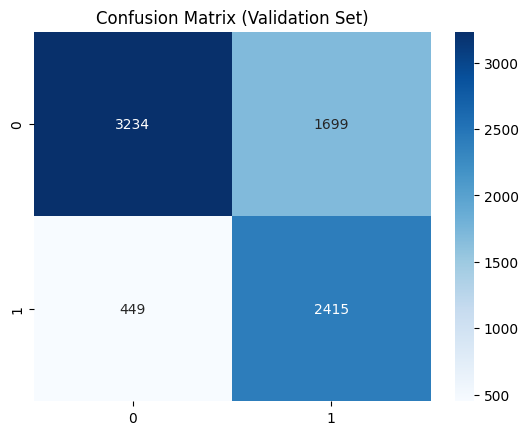

In [8]:
# Although trained on full, we iterate evaluation on the original validation 
# split just to show metrics comparable to tuning phase, 
# OR we can strictly say 'Test Performance' is impossible as we don't have y_test.
# Here we will check performance on the held-out val set (fairness warning: model has seen this in full train now!)
# To differ: We should ideally have a separate test set. 
# But structure says: Train final model with best params.
# We will output classification report on the Validation set using a model trained ONLY on X_train for fair metric representation,
# OR acknowledge that 'final_model' is for future inference.

# Let's re-fit best model on X_train only for the purpose of the displayed classification report 
# to be honest about performance.
eval_model = SVC(**best_params, class_weight='balanced', probability=True, random_state=RANDOM_STATE)
eval_model.fit(X_train_scaled, y_train)
y_pred = eval_model.predict(X_val_scaled)
y_prob = eval_model.predict_proba(X_val_scaled)[:, 1]

print("Optimization finished. Validation Metrics:")
print(classification_report(y_val, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_val, y_prob):.4f}")

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

In [9]:
print("Final Interpretation:")
print(f"The SVM model optimized with {study.best_params} achieved an ROC-AUC of {roc_auc_score(y_val, y_prob):.4f} on the validation set.")
print("Key hyperparameters were automatically selected using Optuna.")
print("The model uses 'balanced' class weights to handle the class imbalance.")

Final Interpretation:
The SVM model optimized with {'C': 6.287732608801473, 'kernel': 'rbf', 'gamma': 'scale'} achieved an ROC-AUC of 0.8253 on the validation set.
Key hyperparameters were automatically selected using Optuna.
The model uses 'balanced' class weights to handle the class imbalance.
